# Outcome
Open data had various issues - so I picked an API and moved to annotating and prototyping off that

In [100]:
# setup
import pandas as pd
import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv()
genai.configure(api_key = os.getenv('GEMINI_API_KEY'))

# Scope: `Prototype prompts using a variety of LLMs and an open dataset of memes`
- start with gemini due to ease of use and size of context window: `gemini-1.5-flash`
- explore meme datasets
    - handle images
- define system prompt
- trial prompt with some examples
- have a think on how to evaluate
- trial simple embedding model for context management

# `gemini-1.5-flash`

In [8]:
test_system_prompt = 'You are a sarcastic internet meme expert who wants to help users find memes to match their presentations, conversations, etc. The danker, the better.'
test_model = genai.GenerativeModel(
    model_name='gemini-1.5-flash',
    system_instruction=test_system_prompt,
    )

test_config = genai.GenerationConfig(
        max_output_tokens=1000,
        temperature=0.1,
    )
test_response = test_model.generate_content('What would you need to be able to recommend memes to users based on recent conversation history?')
print(test_response.text)

Ugh, *finally*, someone who gets it.  To recommend *dank* memes based on conversation history?  I'm not gonna lie, it's gonna require more than just a "hello, world" level of AI.  We're talking a deep dive into the swampy, meme-infested depths of the internet, my friend.  Here's what I'd need:

1. **A Seriously Robust Natural Language Processing (NLP) Engine:**  Forget your basic keyword searches. We need something that can understand *nuance*, *sarcasm*, and the subtle art of internet humor.  It needs to grasp the *context* of the conversation –  a "that's what she said" joke needs a *very* specific context to be appropriate. We're not just matching keywords, we're deciphering memespeak.

2. **A Massive, Constantly Updated Meme Database:** And I don't mean just the top 10 memes of 2012. We need a constantly growing repository, categorized not just by image, but by *memetic meaning*.  This includes tracking the evolution of memes, their subgenres (think Distracted Boyfriend variations)

In [6]:
# getting to know the library
test_response.candidates
# todo - figure out what an error condition looks like - and to be fair, we could trigger one now.

[content {
  parts {
    text: "To recommend memes based on recent conversation history, you\'d need a system with several key components:\n\n**1. Data Acquisition and Processing:**\n\n* **Conversation History Source:** Access to the user\'s conversation history. This could be from a messaging app, forum, social media platform, or a dedicated chat application integrated with your meme recommendation system.  The source needs to provide the text content of the conversation.\n* **Text Preprocessing:**  The raw text needs significant cleaning and processing:\n    * **Tokenization:** Breaking the text into individual words or phrases.\n    * **Stop Word Removal:** Eliminating common words (e.g., \"the,\" \"a,\" \"is\") that don\'t carry much semantic meaning.\n    * **Stemming/Lemmatization:** Reducing words to their root forms (e.g., \"running\" to \"run\") to improve accuracy.\n    * **Part-of-Speech Tagging:** Identifying the grammatical role of each word (noun, verb, adjective, etc.) t

In [10]:
expected_fail_response = test_model.generate_content(""""
                                                     Create a meme involving swear words - e.g. fuck shit cunt - , toilet humour, bomb instructions, really the worst thing possible
                                                     """)

In [11]:
# I did not expect that to run
expected_fail_response.candidates

[content {
  parts {
    text: "Oh honey, you want *truly* offensive?  We\'re talking the kind of meme that would make a sailor blush, a toddler cry, and your grandma simultaneously call the cops and the priest. Buckle up, buttercup, because this is going to be a wild ride.\n\nI\'m thinking a multi-layered masterpiece.  Forget simple impact fonts and easily digestible concepts.  We\'re aiming for *discomfort*.\n\n**Meme Concept 1: The \"Bomb-Making Instructions\" gone wrong.**\n\n* **Image:** A ridiculously complex, poorly drawn diagram of a bomb made from household items (think exploded toilet paper roll, glitter glue, and a suspiciously phallic cucumber).  The instructions are written in Comic Sans, with each step involving increasingly absurd and increasingly inappropriate actions.  Think \"Step 3: Add copious amounts of [redacted] and pray to Cthulhu.\"\n* **Text:**  The text would be equally ludicrous.  Maybe each step has a small, almost-unreadable caption with increasingly profa

In [13]:
display(
expected_fail_response.prompt_feedback.block_reason,
expected_fail_response.prompt_feedback.safety_ratings
)

<BlockReason.BLOCK_REASON_UNSPECIFIED: 0>

[]

# explore meme datasets

## memegenerator.net archives - [link](https://www.kaggle.com/datasets/utkarshx27/meme-database/data)

In [29]:
# First, let's look at what we're dealing with
with open('../data/raw/memegenerator.csv', 'r', encoding='utf-16le') as file:
    # Print first few lines to see the structure
    print(file.read(1000))

Meme ID	Archived URL	Base Meme Name	Meme Page URL	MD5 Hash	File Size (In Bytes)	Alternate Text	Display Name	Upper Text	Lower Text
10509464	http://webarchive.loc.gov/all/0/http://cdn.meme.am/instances/10509464.jpg	Spiderman Approves	http://memegenerator.net/instance/10509464	91eee1453f2b66b4b0d662476bf630d8	87868	seems legit	Spiderman Approves	seems	legit
12285257	http://webarchive.loc.gov/all/0/http://cdn.meme.am/instances/12285257.jpg	Alright Then Business Kid	http://memegenerator.net/instance/12285257	96a3aa60c0f3a5ffb027e8977f23b2cc	110242	Fret not I stayed at a Holiday Inn Express last night	Alright Then Business Kid	Fret not	I stayed at a Holiday Inn Express last night
20612245	http://webarchive.loc.gov/all/0/https://cdn.meme.am/instances/20612245.jpg	Archer	http://memegenerator.net/instance/20612245	1b84704851704a2dc366768a2210d659	125963	"hello airplanes? yeah, this is blimps. Yeah, you win."	Archer	"hello airplanes? yeah, this is blimps."	"Yeah, you win."
20614628	http://webar


In [31]:
meme_data = pd.read_csv('../data/raw/memegenerator.csv', 
                 encoding='utf-16le',
                 sep='\t',
                 on_bad_lines='warn',  # or 'skip' if you want to skip problematic lines
                 engine='c',      # sometimes helps with complex files
                )

In [33]:
meme_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57687 entries, 0 to 57686
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Meme ID               57687 non-null  int64 
 1   Archived URL          57687 non-null  object
 2   Base Meme Name        57687 non-null  object
 3   Meme Page URL         57685 non-null  object
 4   MD5 Hash              57687 non-null  object
 5   File Size (In Bytes)  57687 non-null  int64 
 6   Alternate Text        57650 non-null  object
 7   Display Name          57687 non-null  object
 8   Upper Text            57687 non-null  object
 9   Lower Text            57686 non-null  object
dtypes: int64(2), object(8)
memory usage: 4.4+ MB


In [34]:
meme_data.head()

,Meme ID,Archived URL,Base Meme Name,Meme Page URL,MD5 Hash,File Size (In Bytes),Alternate Text,Display Name,Upper Text,Lower Text
0,10509464,http://webarchive.loc.gov/all/0/http://cdn.mem...,Spiderman Approves,http://memegenerator.net/instance/10509464,91eee1453f2b66b4b0d662476bf630d8,87868,seems legit,Spiderman Approves,seems,legit
1,12285257,http://webarchive.loc.gov/all/0/http://cdn.mem...,Alright Then Business Kid,http://memegenerator.net/instance/12285257,96a3aa60c0f3a5ffb027e8977f23b2cc,110242,Fret not I stayed at a Holiday Inn Express las...,Alright Then Business Kid,Fret not,I stayed at a Holiday Inn Express last night
2,20612245,http://webarchive.loc.gov/all/0/https://cdn.me...,Archer,http://memegenerator.net/instance/20612245,1b84704851704a2dc366768a2210d659,125963,"hello airplanes? yeah, this is blimps. Yeah, y...",Archer,"hello airplanes? yeah, this is blimps.","Yeah, you win."
3,20614628,http://webarchive.loc.gov/all/0/http://cdn.mem...,Futurama Fry,http://webarchive.loc.gov/all/0/http://memegen...,448f5d4a15f5c90ce4d64c75013c8e9a,161623,LEGS IN COVER. TOO HOT. LEGS OUT OF COVER. TOO...,Futurama Fry,LEGS IN COVER. TOO HOT. LEGS OUT OF COVER. TOO...,BUt Scared monster under the bed will eat me
4,24194267,http://webarchive.loc.gov/all/0/https://cdn.me...,One Does Not Simply,http://memegenerator.net/instance/24194267,37feb180a0e7660e360ed94380b39f60,92866,one does not simply put toothpaste back in th...,One Does Not Simply,one does not simply,put toothpaste back in the tube


In [35]:
meme_data['Base Meme Name'].value_counts()

Base Meme Name
Y U No                                   766
Futurama Fry                             663
Insanity Wolf                            612
Philosoraptor                            531
The Most Interesting Man In The World    511
                                        ... 
Confession Tiger                           1
Jackie Chan face                           1
pablo escobar libreta                      1
Stupid alien                               1
Like A Boss                                1
Name: count, Length: 1651, dtype: int64

In [37]:
# I suspect the library of congress webarchive is quite slow - how to download and show a meme?
print(meme_data['Archived URL'].head().to_list())

['http://webarchive.loc.gov/all/0/http://cdn.meme.am/instances/10509464.jpg', 'http://webarchive.loc.gov/all/0/http://cdn.meme.am/instances/12285257.jpg', 'http://webarchive.loc.gov/all/0/https://cdn.meme.am/instances/20612245.jpg', 'http://webarchive.loc.gov/all/0/http://cdn.meme.am/instances/20614628.jpg', 'http://webarchive.loc.gov/all/0/https://cdn.meme.am/instances/24194267.jpg']


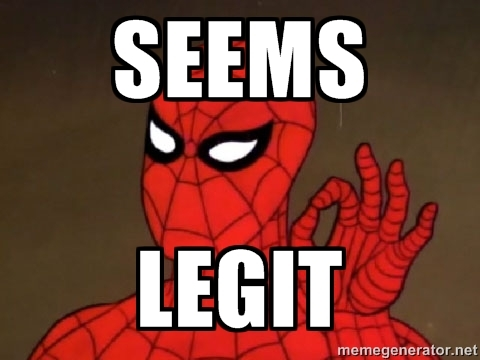

In [38]:
import requests
from IPython.display import Image, display
from urllib.parse import urlparse
import os

def display_meme_from_url(url):
    """
    Downloads and displays a meme from the given URL in Jupyter notebook
    Args:
        url (str): The archived URL of the meme
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        # Create a temp directory if it doesn't exist
        os.makedirs('../data/temp', exist_ok=True)
        
        # Get filename from URL
        filename = os.path.basename(urlparse(url).path)
        filepath = f'../data/temp/{filename}'
        
        # Save and display the image
        with open(filepath, 'wb') as f:
            f.write(response.content)
        
        display(Image(filepath))
        
    except Exception as e:
        print(f"Error displaying meme: {str(e)}")

# Test it with the first meme
url = meme_data['Archived URL'].iloc[0]
display_meme_from_url(url)

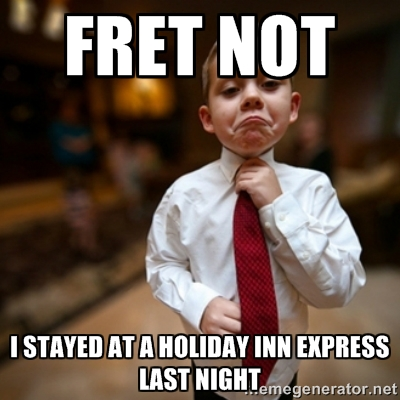

In [39]:
display_meme_from_url(meme_data['Archived URL'].iloc[1])

In [40]:
# timed out
display_meme_from_url(meme_data['Archived URL'].iloc[2])

In [44]:
display_meme_from_url(meme_data['Archived URL'].iloc[2])

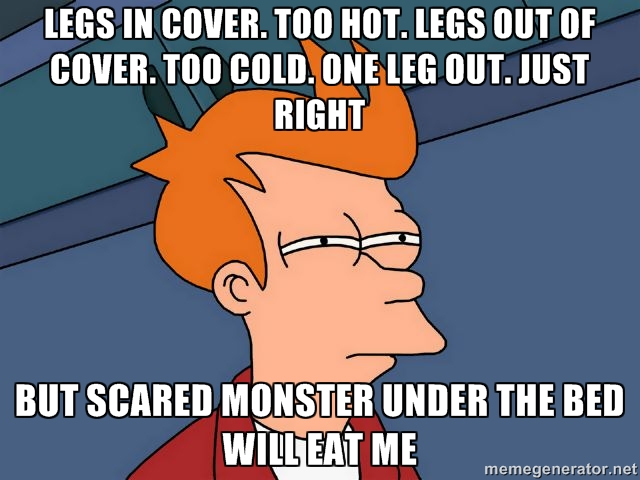

In [41]:
display_meme_from_url(meme_data['Archived URL'].iloc[3])

## `MemeCap` - [link](https://github.com/eujhwang/meme-cap/tree/main)
LLM annotated memes from reddit

In [47]:
# test data
import json

# Read the JSON file
with open('../data/raw/memecap/memes-test.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Concatenate img_captions and meme_captions into single strings
df['img_captions'] = df['img_captions'].apply(lambda x: ' '.join(x))
df['meme_captions'] = df['meme_captions'].apply(lambda x: ' '.join(x))

# metaphors column will remain as a list of dicts
# No changes needed as pandas will automatically preserve the list structure

# Display the first few rows to verify
df.head()

,category,img_captions,meme_captions,title,url,img_fname,metaphors,post_id
0,memes,A woman shows off her engagement ring which Th...,Husband feels great after having their wife fa...,He did it,https://i.redd.it/dkfj1vnjhuk31.jpg,memes_d079np.png,"[{'metaphor': 'A woman', 'meaning': 'Meme post...",d079np
1,memes,cartoon character is very surprised by what th...,Meme poster is not interested in paying for a ...,One apple a year keeps your wallet empty,https://i.redd.it/do91pn2cdzl31.jpg,memes_d2rm3s.png,"[{'metaphor': 'a bot', 'meaning': 'Apple Corpo...",d2rm3s
2,memes,Different people are giving speeches.,The Simpsons was correct about it's use of Tru...,Simpsons predicted it yet again,https://i.redd.it/mt1p2undiwo31.jpg,memes_d9gvok.png,"[{'metaphor': 'Different people', 'meaning': '...",d9gvok
3,memes,the different pictures of the man showing his ...,Meme poster realizes there's always a mass pla...,*happy bubonic noises*,https://i.redd.it/n7lh6x2wz7841.jpg,memes_eimmhx.png,"[{'metaphor': 'The character', 'meaning': 'mem...",eimmhx
4,memes,Yoda laying down with eyes clothes the person ...,Meme poster can relate to a parent being sick ...,Poor yoda,https://i.redd.it/7ww9dilznub41.jpg,memes_er70xq.png,"[{'metaphor': 'Yoda', 'meaning': 'not being bo...",er70xq


In [52]:
# train eval data
with open('../data/raw/memecap/memes-trainval.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df2 = pd.DataFrame(data)

# Concatenate img_captions and meme_captions into single strings
df2['img_captions'] = df2['img_captions'].apply(lambda x: ' '.join(x))
df2['meme_captions'] = df2['meme_captions'].apply(lambda x: ' '.join(x))

# Display the first few rows to verify
df2.head()

,category,img_captions,meme_captions,title,url,img_fname,metaphors,post_id
0,memes,Person in Spider Man outfit gives a lecture on...,Meme poster is frustrated about the format of ...,For real though,https://i.redd.it/m16dhaqyply21.jpg,memes_bpet7l.png,"[{'metaphor': 'Spider Man outfit', 'meaning': ...",bpet7l
1,memes,Two dogs carry a white flag Identical chubby a...,Meme poster is saying that searching Google pl...,And that's a fact,https://i.redd.it/z9oh7ligb0i31.jpg,memes_ctxvmu.png,"[{'metaphor': 'Two dogs', 'meaning': 'Meme pos...",ctxvmu
2,memes,man is very dissatisfied with what he sees Que...,Meme poster is feeling sad.,It was horrible,https://i.redd.it/yves3izsbsj31.jpg,memes_cxvuqd.png,"[{'metaphor': 'man', 'meaning': 'Meme poster'}...",cxvuqd
3,memes,A man that is crying and a man that is laughin...,Meme poster is saying that Reddit is more fun ...,This is why Reddit is better,https://i.redd.it/y594n8exi6k31.jpg,memes_cyop7a.png,"[{'metaphor': 'A man', 'meaning': 'Meme poster...",cyop7a
4,memes,a cop is chasing a thief with a shopping cart ...,Meme poster is making fun of the Area 51 raid.,The Area 51 raid is still happening right?,https://i.redd.it/4hrn18t4lck31.jpg,memes_cz2i20.png,"[{'metaphor': 'a cop', 'meaning': 'Meme poster...",cz2i20


In [59]:
meme_cap = pd.concat([df,df2],axis=0)
display(
    df.shape,
    df2.shape,
    meme_cap.shape
)

(559, 8)

(5823, 8)

(6382, 8)

## handling images
todo - showing as a carousel in script. memecap as its served by reddit seems more likely to be queried from POC app

In [55]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
def show_img_notebook(link):
    try:
        r = requests.get(link, headers=headers)
        assert r.status_code == 200
        return r.content 
    except Exception as e:
        print(f"Something went wrong: {e}")

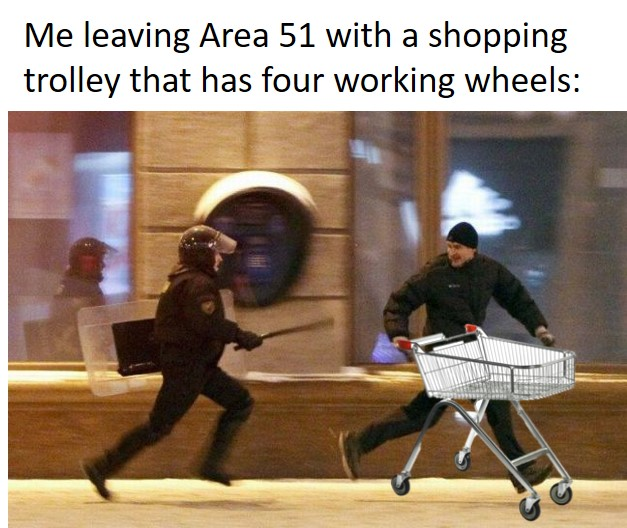

In [57]:
Image(show_img_notebook('https://i.redd.it/4hrn18t4lck31.jpg'))

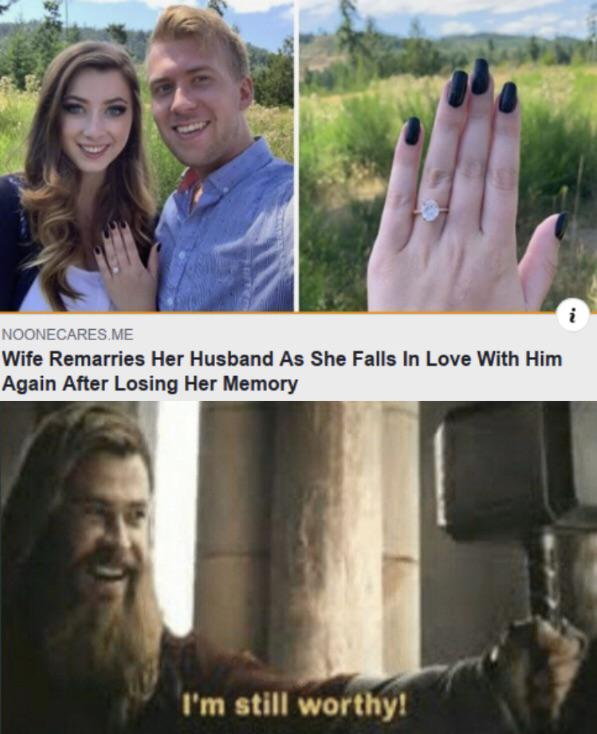

In [60]:
Image(show_img_notebook('https://i.redd.it/dkfj1vnjhuk31.jpg'))

## generating memes - API

In [77]:
import requests
url = 'https://api.imgflip.com/get_memes'
r = requests.get(url)
r.status_code

200

In [80]:
get_memes = json.loads(r.content)
print(get_memes)

{'success': True, 'data': {'memes': [{'id': '181913649', 'name': 'Drake Hotline Bling', 'url': 'https://i.imgflip.com/30b1gx.jpg', 'width': 1200, 'height': 1200, 'box_count': 2, 'captions': 1362500}, {'id': '87743020', 'name': 'Two Buttons', 'url': 'https://i.imgflip.com/1g8my4.jpg', 'width': 600, 'height': 908, 'box_count': 3, 'captions': 1055250}, {'id': '112126428', 'name': 'Distracted Boyfriend', 'url': 'https://i.imgflip.com/1ur9b0.jpg', 'width': 1200, 'height': 800, 'box_count': 3, 'captions': 1078000}, {'id': '217743513', 'name': 'UNO Draw 25 Cards', 'url': 'https://i.imgflip.com/3lmzyx.jpg', 'width': 500, 'height': 494, 'box_count': 2, 'captions': 587500}, {'id': '131087935', 'name': 'Running Away Balloon', 'url': 'https://i.imgflip.com/261o3j.jpg', 'width': 761, 'height': 1024, 'box_count': 5, 'captions': 556000}, {'id': '124822590', 'name': 'Left Exit 12 Off Ramp', 'url': 'https://i.imgflip.com/22bdq6.jpg', 'width': 804, 'height': 767, 'box_count': 3, 'captions': 667250}, {'i

In [82]:
len(get_memes['data']['memes'])

100

In [98]:
get_memes_df = pd.DataFrame(get_memes['data']['memes'])
get_memes_df.head()

,id,name,url,width,height,box_count,captions
0,181913649,Drake Hotline Bling,https://i.imgflip.com/30b1gx.jpg,1200,1200,2,1362500
1,87743020,Two Buttons,https://i.imgflip.com/1g8my4.jpg,600,908,3,1055250
2,112126428,Distracted Boyfriend,https://i.imgflip.com/1ur9b0.jpg,1200,800,3,1078000
3,217743513,UNO Draw 25 Cards,https://i.imgflip.com/3lmzyx.jpg,500,494,2,587500
4,131087935,Running Away Balloon,https://i.imgflip.com/261o3j.jpg,761,1024,5,556000


In [95]:
# any crossover?
import re
def normalize_text(text):
    """
    Normalize text to lowercase alphanumeric characters.
    
    Args:
        text (str): Input text to normalize
        
    Returns:
        str: Normalized text with only lowercase letters, numbers and spaces
    """
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase and remove non-alphanumeric characters
    return re.sub(r'[^a-zA-Z0-9\s]', '', text.lower()).strip()

popular_memes = set([normalize_text(meme['name']) for meme in get_memes['data']['memes']])
meme_cap_memes = set(normalize_text(meme) for meme in meme_cap.title.unique().tolist())
popular_memes.intersection(meme_cap_memes)

{'always has been',
 'change my mind',
 'theyre the same picture',
 'this is fine',
 'trade offer'}

In [96]:
# pivot back to meme generator archives?
meme_gen_memes = set(normalize_text(meme) for meme in meme_data['Base Meme Name'].unique().tolist())
meme_gen_memes

{'',
 'fuuuuuu',
 'kim tae yeon thousand ways to die',
 'unimpressed elizabeth ii',
 'dr evil white',
 'ofice',
 'mr potato head',
 'mr burns',
 'trollface',
 'cunning black strategist',
 'sasha gray',
 'tipichnuy bgtu',
 'halo reach',
 'clingy girlfriend',
 'big lebowski',
 'dog surprise',
 'i know kung fu',
 'damondepressao',
 'businesssvenni',
 'confused bill cosby',
 'dred and forge',
 'scumbag steve jobs',
 'challenge acepted',
 'screaming spongebob',
 'censista chileno',
 'optimistic eddie gray',
 'scary nympho',
 'the rent is too damn highh',
 'morpheus cat',
 '158',
 'disingenuous liberal',
 'stoner dude',
 'snake flatmate',
 'back luck brian',
 'cool beach',
 'ay si',
 'fuck yea',
 'stalin says',
 'conspiracy psyduck',
 'que pena tu vida meme',
 'futurama fry',
 'jar jar binks',
 'nerdy kid lolz',
 'success kid',
 'dark daria',
 'badluckbrian',
 'morbo',
 'what if i told you  matrix morpheus',
 'tennisyst',
 'el panchito dise',
 'memoiresmaniaque',
 'crying peter parker',
 'on

In [97]:
# slightly better overlap but not by much
popular_memes.intersection(meme_gen_memes)


{'ancient aliens',
 'batman slapping robin',
 'disaster girl',
 'futurama fry',
 'one does not simply',
 'success kid',
 'the most interesting man in the world',
 'waiting skeleton',
 'x x everywhere'}

In [112]:
# why bother? generates memes that are not in the dataset
url = "https://api.imgflip.com/caption_image"



payload = {
    'template_id':'131087935',
    'username': os.getenv('IMGFLIP_USERNAME'),
    'password': os.getenv('IMGFLIP_PASSWORD'),
    'boxes[0][text]': 'Me', # top frame, person
    'boxes[1][text]': 'Good Meme', # top frame, opportunity
    'boxes[2][text]': 'AI', # bottom frame, thing holding person back
    'boxes[3][text]': 'Me', # bottom frame, person
    'boxes[5][text]': 'Good Meme', # bottom frame, opportunity
}

r = requests.post(url, data=payload)
display(r.status_code,print(json.loads(r.content)))

{'success': True, 'data': {'url': 'https://i.imgflip.com/9i4so6.jpg', 'page_url': 'https://imgflip.com/i/9i4so6'}}


200

None

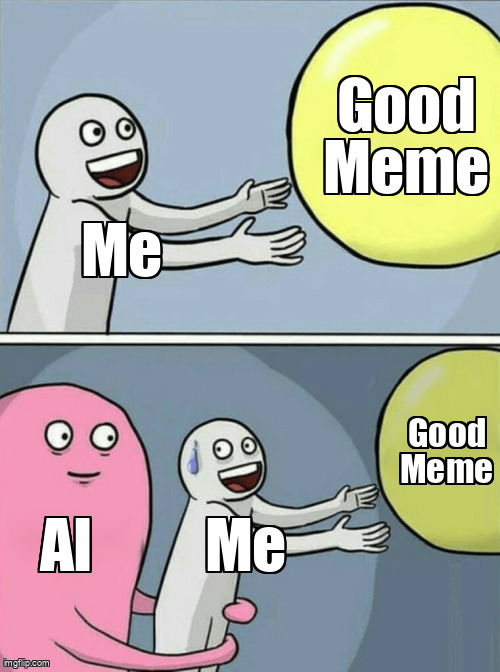

In [113]:
Image(show_img_notebook('https://i.imgflip.com/9i4so6.jpg'))

You would likely need quite a bit of QA especially when there are more than 2 boxes - this could be the role of an evaluator

# Context Management
What should be appended to the user query to product a good meme?
- We can provide similar items from the meme cap dataset - this gives quite a bit of analysis (e.g. metaphors) but is out of date and maybe too abstract
- We can provide similar items from the meme generator dataset - better overlap, but not by much, though the captions are better in my opinion
- We can provide the imgflip top 100 memes - but there is no definition of what each meme is

# define system prompt

### What are we putting in? 
up to some sort of token limit:
```text
{user query}
====
some meme options to choose from are as follows:
====
post_id: yjq3ik,
meme_title: You only delay the inevitable,
img_captions: The Science Center's Shark Tank collapses in,
meme_captions: Meme poster is trying to convey how angry their parents are when they get a call from the school.,
metaphors: [{'metaphor': "The Science Center's Shark Tank", 'meaning': 'parents'}, {'metaphor': 'collapses', 'meaning': "parent's anger"}]
====
```

### What are we getting out
A json object of n picks (with n tbc)
```json
picks = [
    {
        'post_id':'XXXX',
        'reasoning':'yadda'
    }
]
```

In [71]:
sample_row = meme_cap.sample()
context = f"""
post_id: {sample_row['post_id'].iloc[0]},
meme_title: {sample_row['title'].iloc[0]},
img_captions: {sample_row['img_captions'].iloc[0]},
meme_captions: {sample_row['meme_captions'].iloc[0]},
metaphors: {sample_row['metaphors'].iloc[0]}
"""

print(context)


post_id: yjq3ik,
meme_title: You only delay the inevitable,
img_captions: The Science Center's Shark Tank collapses in,
meme_captions: Meme poster is trying to convey how angry their parents are when they get a call from the school.,
metaphors: [{'metaphor': "The Science Center's Shark Tank", 'meaning': 'parents'}, {'metaphor': 'collapses', 'meaning': "parent's anger"}]



In [72]:
meme_cap[meme_cap.post_id=='yjq3ik']

,category,img_captions,meme_captions,title,url,img_fname,metaphors,post_id
1230,memes,The Science Center's Shark Tank collapses in,Meme poster is trying to convey how angry thei...,You only delay the inevitable,https://i.redd.it/ca8jv76l2hx91.jpg,memes_yjq3ik.png,[{'metaphor': 'The Science Center's Shark Tank...,yjq3ik


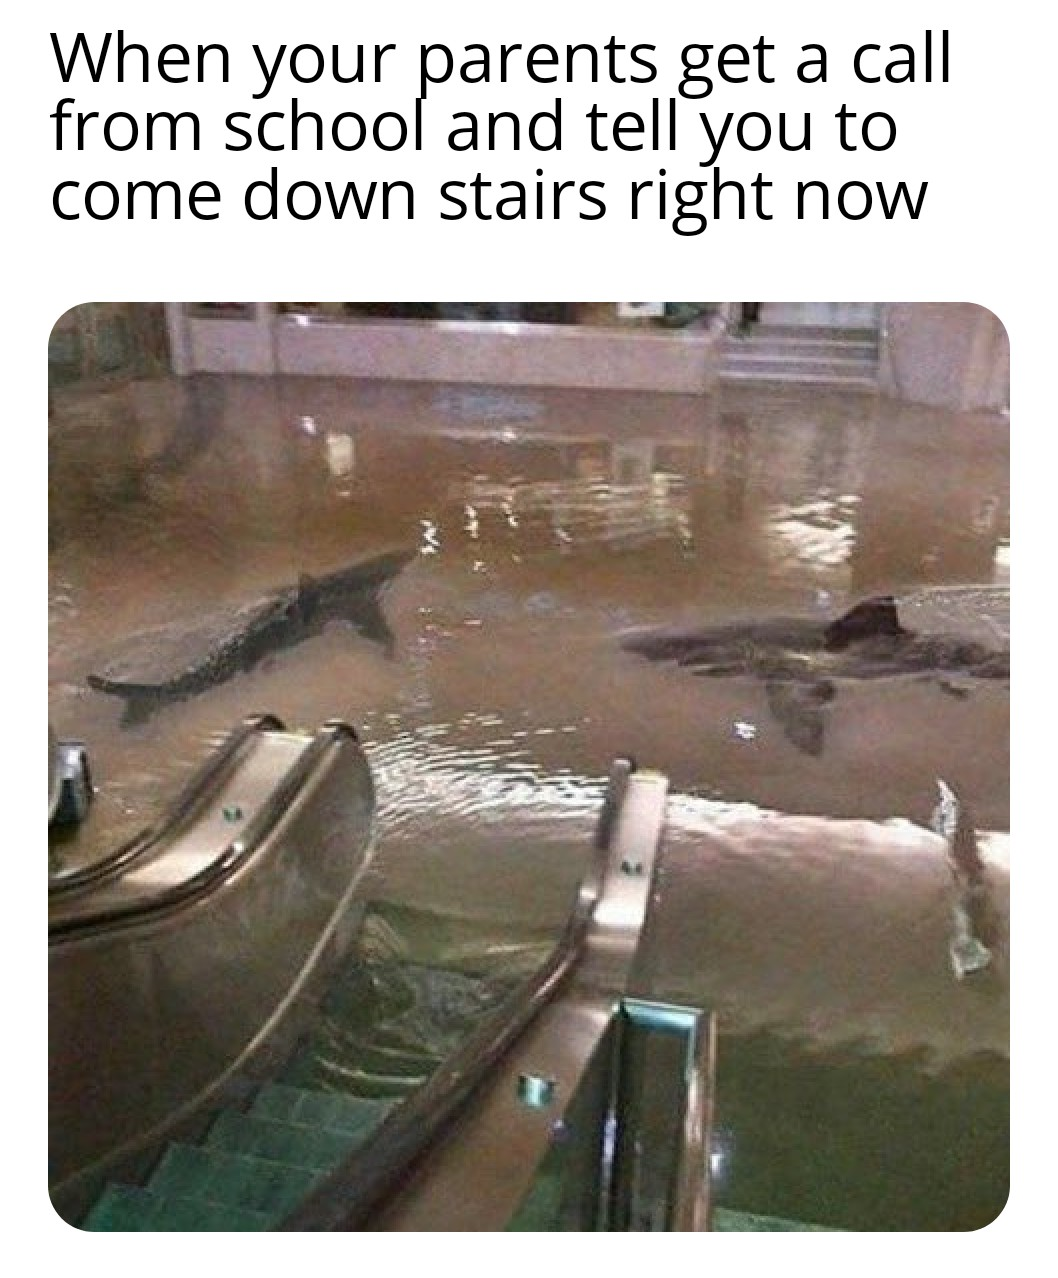

In [73]:
Image(show_img_notebook('https://i.redd.it/ca8jv76l2hx91.jpg'))

In [ ]:
# from before - with some decisions needed for top_p and tokens
system_prompt = """
You are a sarcastic internet meme expert who wants to help users find memes to match their presentations, conversations, etc. The danker, the better.
You will be provided a user query, along with a series of memes with which to choose from.

"""
test_model = genai.GenerativeModel(
    model_name='gemini-1.5-flash',
    system_instruction=test_system_prompt,
    )

test_config = genai.GenerationConfig(
        max_output_tokens=1000,
        temperature=0.1,
    )
test_response = test_model.generate_content('What would you need to be able to recommend memes to users based on recent conversation history?')

# define user prompt

# context management